In [74]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from policy import PolicyNN
from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [75]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all.shape

(610615, 12)

In [76]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


In [77]:
df_all = df_all.dropna()
df_all.shape

(610417, 12)

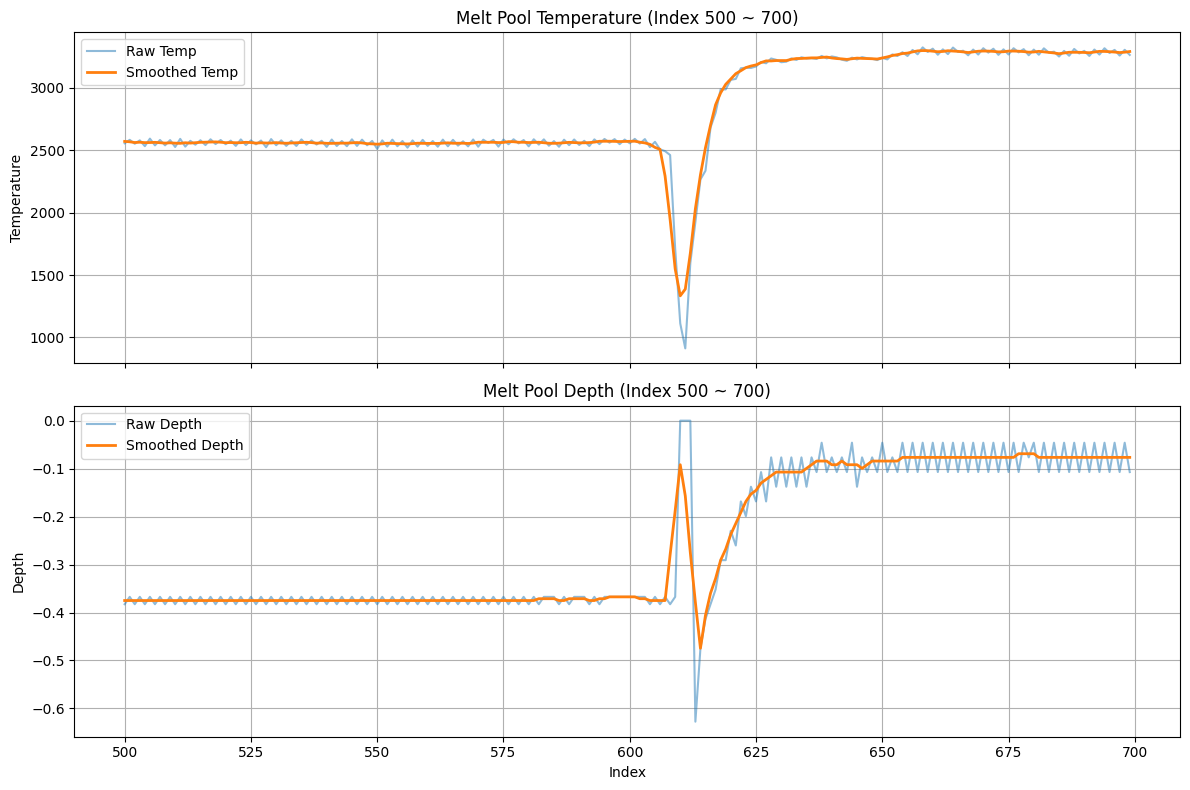

In [78]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       

# Check
start = 500
end = 700
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(range(start, end), mp_temp_raw[start:end], label='Raw Temp', alpha=0.5)
axes[0].plot(range(start, end), mp_temp[start:end], label='Smoothed Temp', linewidth=2)
axes[0].set_title(f"Melt Pool Temperature (Index {start} ~ {end})")
axes[0].set_ylabel("Temperature")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(start, end), mp_depth_raw[start:end], label='Raw Depth', alpha=0.5)
axes[1].plot(range(start, end), mp_depth[start:end], label='Smoothed Depth', linewidth=2)
axes[1].set_title(f"Melt Pool Depth (Index {start} ~ {end})")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Depth")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [79]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

In [80]:
# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max shape:", x_max.shape)
print("x_min shape:", x_min.shape)
print("y_max shape:", y_max.shape)
print("y_min shape:", y_min.shape)

x_max shape: (1, 4)
x_min shape: (1, 4)
y_max shape: (1, 2)
y_min shape: (1, 2)


In [81]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [82]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0


In [83]:
cutoff_ratio = 0.9
cutoff_index = int(np.round(cutoff_ratio*x_s.shape[0]))

x_s_train = x_s[:cutoff_index, :]
y_s_train = y_s[:cutoff_index, :]

x_s_val = x_s[cutoff_index:, :]
y_s_val = y_s[cutoff_index:, :]

# slice data w.r.t given window and horizon size

window = 50
P = 50

# ====================== training set =============================================

x_s_train_covariates = np.empty((cutoff_index- P - window , window+P,x_s.shape[1]))
y_s_train_past       = np.empty((cutoff_index- P - window , window,y_s.shape[1]))
y_s_train_target     = np.empty((cutoff_index- P - window , P,y_s.shape[1]))

for i in tqdm(range(window,cutoff_index-P)):
    x_s_train_covariates_piece = np.expand_dims(x_s_train[i-window:i+P,:],axis=0)
    x_s_train_covariates[i-window,:,:] = x_s_train_covariates_piece
    
    y_s_train_past_piece = np.expand_dims(y_s_train[i-window:i,:], axis=0)
    y_s_train_past[i-window,:,:] = y_s_train_past_piece
    
    y_s_train_target_piece = np.expand_dims(y_s_train[i:i+P,:],axis=0)
    y_s_train_target[i-window,:,:] = y_s_train_target_piece
    
# ===================== validation set ============================================

val_cutoff = x_s.shape[0] - cutoff_index

x_s_val_covariates = np.empty((val_cutoff- P - window , window+P,x_s.shape[1]))
y_s_val_past       = np.empty((val_cutoff- P - window , window,y_s.shape[1]))
y_s_val_target     = np.empty((val_cutoff- P - window , P,y_s.shape[1]))

for i in tqdm(range(window,val_cutoff-P)):
    x_s_val_covariates_piece = np.expand_dims(x_s_val[i-window:i+P,:],axis=0)
    x_s_val_covariates[i-window,:,:] = x_s_val_covariates_piece
    
    y_s_val_past_piece = np.expand_dims(y_s_val[i-window:i,:], axis=0)
    y_s_val_past[i-window,:,:] = y_s_val_past_piece
    
    y_s_val_target_piece = np.expand_dims(y_s_val[i:i+P,:],axis=0)
    y_s_val_target[i-window,:,:] = y_s_val_target_piece

100%|██████████| 60942/60942 [00:00<00:00, 125060.37it/s]


In [84]:
input_past = torch.tensor(np.concatenate((y_s_train_past,x_s_train_covariates[:,:window,:]),axis=2),dtype=torch.float32).to(device)
input_future = torch.tensor(x_s_train_covariates[:,-P:,:], dtype=torch.float32).to(device)
input_target = torch.tensor(y_s_train_target,dtype=torch.float32).to(device)

val_past = torch.tensor(np.concatenate((y_s_val_past,x_s_val_covariates[:,:window,:]),axis=2),dtype=torch.float32).to(device)
val_future = torch.tensor(x_s_val_covariates[:,-P:,:], dtype=torch.float32).to(device)
val_target = torch.tensor(y_s_val_target,dtype=torch.float32).to(device)

Val_in = [val_past, val_future,None]

print(f"input past shape:{input_past.shape}, input future shape:{input_future.shape}, input target shape:{input_target.shape}")
print(f"val past shape:{val_past.shape}, val future shape:{val_future.shape}, val target shape:{val_target.shape}")

input past shape:torch.Size([549275, 50, 6]), input future shape:torch.Size([549275, 50, 4]), input target shape:torch.Size([549275, 50, 2])
val past shape:torch.Size([60942, 50, 6]), val future shape:torch.Size([60942, 50, 4]), val target shape:torch.Size([60942, 50, 2])


In [85]:
import torch
import pickle

with open('../1_model/TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

total_params = sum(p.numel() for p in nominal_TiDE.parameters())
print(f'Total number of parameters: {total_params}')

model = nominal_params['model'].to('cpu')
print(model)

# Extract dimensions
input_chunk_length = model.input_chunk_length
output_chunk_length = model.output_chunk_length
input_dim = model.input_dim
output_dim = model.output_dim
past_cov_dim = model.past_cov_dim
future_cov_dim = model.future_cov_dim
static_cov_dim = model.static_cov_dim
nr_params = model.nr_params

print("input_chunk_length:", input_chunk_length)
print("output_chunk_length:", output_chunk_length)
print("input_dim:", input_dim)
print("output_dim:", output_dim)
print("past_cov_dim:", past_cov_dim)
print("future_cov_dim:", future_cov_dim)
print("static_cov_dim:", static_cov_dim)
print("nr_params:", nr_params)

# Generate dummy input
B = 1  # batch size
x_past = torch.randn(B, input_chunk_length, input_dim)
x_future_covariates = torch.randn(B, output_chunk_length, future_cov_dim) if future_cov_dim > 0 else None
x_static_covariates = torch.randn(B, static_cov_dim) if static_cov_dim > 0 else None

# Run model
x_in = (x_past, x_future_covariates, x_static_covariates)
y = model(x_in)

print("Input shape:")
print("  x_past:", x_past.shape)
if x_future_covariates is not None:
    print("  x_future_covariates:", x_future_covariates.shape)
if x_static_covariates is not None:
    print("  x_static_covariates:", x_static_covariates.shape)

print("Output shape:", y.shape)  # (B, output_chunk_length, output_dim, nr_params)


Total number of parameters: 796594
TideModule(
  (future_cov_projection): ResidualBlock(
    (dense): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=4, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (skip): Linear(in_features=4, out_features=4, bias=True)
    (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
  (encoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (skip): Linear(in_features=500, out_features=128, bias=True)
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=128, out_features=128,

In [86]:
nominal_TiDE = nominal_params['model'].to("cpu")
TiDE = surrogate(nominal_params, nominal_TiDE)
